In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import datetime
import psycopg2
import numpy as np
import pandas as pd
import polars as pl
from venn import venn
from datetime import date
import matplotlib.cm as cm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT"))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DATA_FOLDER = os.getenv("DATA_FOLDER")

In [3]:
bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

In [4]:
if "events.csv" not in os.listdir(DATA_FOLDER):
    with bigbrotr.cursor() as cur:
        with open(os.path.join(DATA_FOLDER, 'events.csv'), 'w') as f:
            # Usa COPY per esportare i dati in CSV
            cur.copy_expert("COPY (SELECT id, pubkey, created_at, kind FROM events) TO STDOUT WITH CSV HEADER", f)
events = pl.read_csv(os.path.join(DATA_FOLDER, 'events.csv'))

In [5]:
# numero totale di eventi e numero totale di pubkey
total_events = events.shape[0]
total_pubkeys = events['pubkey'].n_unique()
print(f"Numero totale di eventi: {total_events}")
print(f"Numero totale di pubkey: {total_pubkeys}")

Numero totale di eventi: 172664903
Numero totale di pubkey: 19681031


In [6]:
kind_counts = events.select(
    pl.col("kind").value_counts()
)
kind_counts = pd.DataFrame(kind_counts.to_pandas())
kind_counts['count'] = kind_counts['kind'].apply(lambda x: x['count'])
kind_counts['kind'] = kind_counts['kind'].apply(lambda x: x['kind'])
kind_counts = kind_counts.sort_values('count', ascending=False).reset_index(drop=True)
kind_counts['perc'] = kind_counts['count'] / kind_counts['count'].sum() * 100
kind_counts.head(20)

,kind,count,perc
0,1,67266176,38.957643
1,7,32614859,18.889107
2,4,9715277,5.626666
3,0,8163256,4.727803
4,3,7837013,4.538857
5,6,7591314,4.396559
6,5,5382124,3.117092
7,9735,4858240,2.813681
8,1000,4508139,2.610918
9,1059,3751739,2.172844


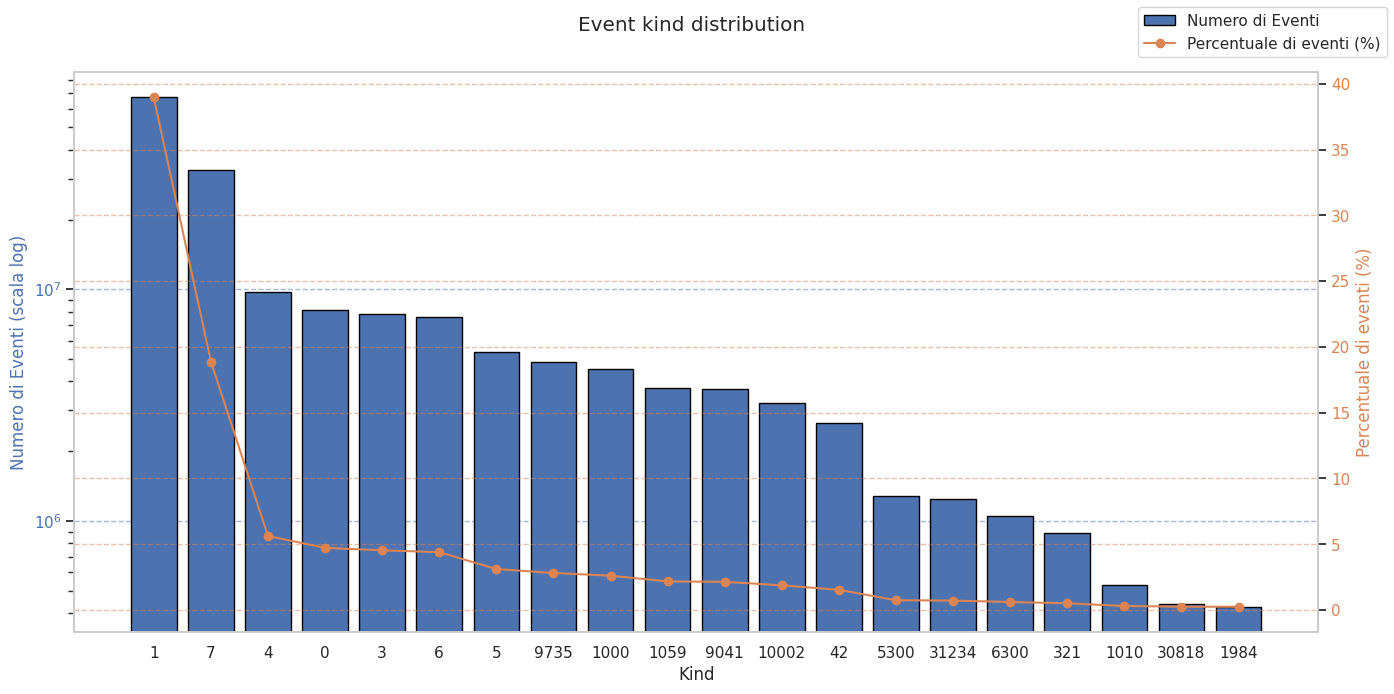

In [7]:
# Selezione dei primi 20 valori
df_plot = kind_counts.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Eventi', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Eventi (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # Rendi trasparente lo sfondo per non coprire le barre

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di eventi (%)', zorder=3)
ax2.set_ylabel('Percentuale di eventi (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind distribution')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [8]:
kind_share = events.unique(subset=["kind", "pubkey"])
kind_share = kind_share.select(
    pl.col("kind").value_counts()
)
kind_share = pd.DataFrame(kind_share.to_pandas())
kind_share['count'] = kind_share['kind'].apply(lambda x: x['count'])
kind_share['kind'] = kind_share['kind'].apply(lambda x: x['kind'])
kind_share = kind_share.sort_values('count', ascending=False).reset_index(drop=True)
kind_share['perc'] = kind_share['count'] / kind_share['count'].sum() * 100

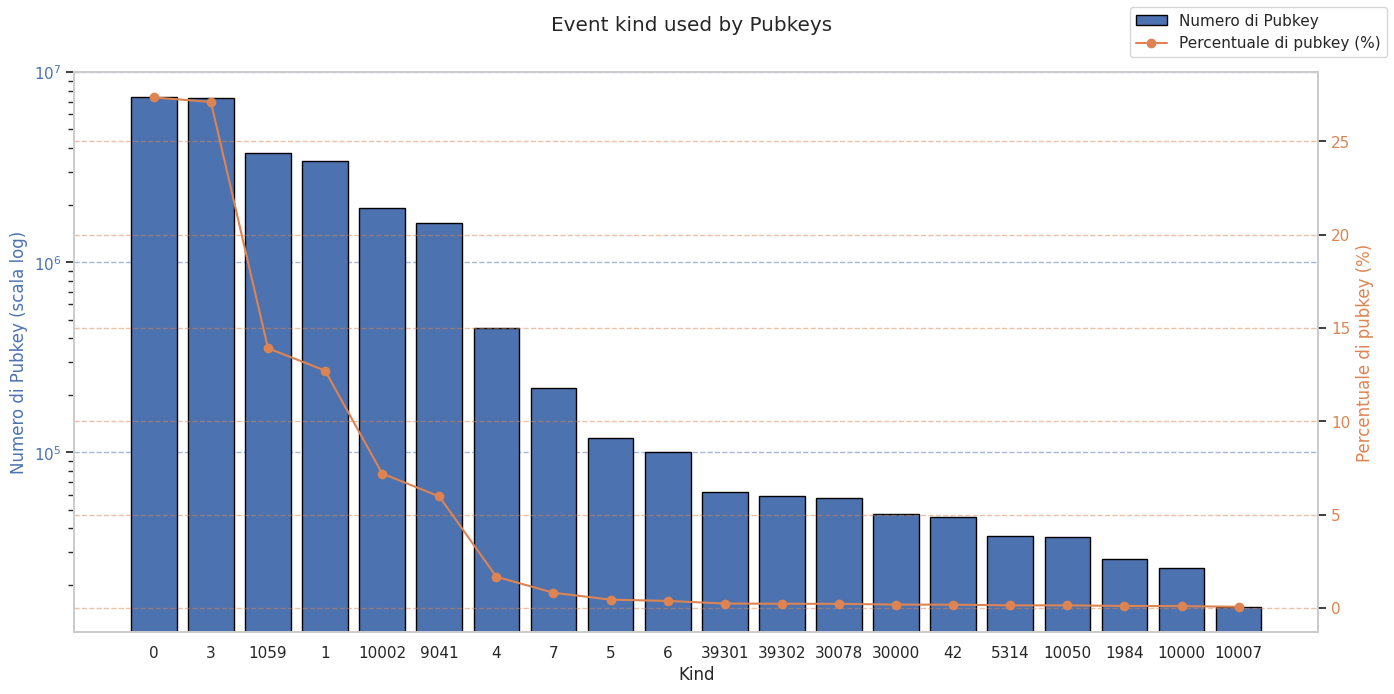

In [9]:
# Selezione dei primi 20 valori
df_plot = kind_share.head(20)
kind_labels = df_plot['kind'].astype(str)

# Impostazione della figura
fig, ax1 = plt.subplots(figsize=(14, 7))

# Colori personalizzati
color_count = '#4C72B0'  # blu tenue
color_perc = '#DD8452'   # arancione

# --- Griglia asse primario ---
ax1.grid(axis='y', linestyle='--', color=color_count, alpha=0.5, zorder=0)
ax1.grid(axis='x', visible=False)

# --- Istogramma (barre) ---
ax1.bar(kind_labels, df_plot['count'], color=color_count, edgecolor='black',
        label='Numero di Pubkey', zorder=1)
ax1.set_xlabel('Kind')
ax1.set_ylabel('Numero di Pubkey (scala log)', color=color_count)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color_count)

# --- Asse secondario per la linea ---
ax2 = ax1.twinx()
ax2.patch.set_visible(False)  # sfondo trasparente

# --- Linea percentuale ---
ax2.plot(kind_labels, df_plot['perc'], color=color_perc, marker='o',
         label='Percentuale di pubkey (%)', zorder=3)
ax2.set_ylabel('Percentuale di pubkey (%)', color=color_perc)
ax2.tick_params(axis='y', labelcolor=color_perc)

# --- Griglia asse secondario ---
ax2.grid(axis='y', linestyle='--', color=color_perc, alpha=0.5, zorder=0)

# --- Titolo e legenda ---
fig.suptitle('Event kind used by Pubkeys')

# Legenda combinata
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
fig.legend(lines_labels, labels)

# Layout finale
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [10]:
merged = kind_share.merge(kind_counts, on='kind', suffixes=('_pubkey', '_event'))

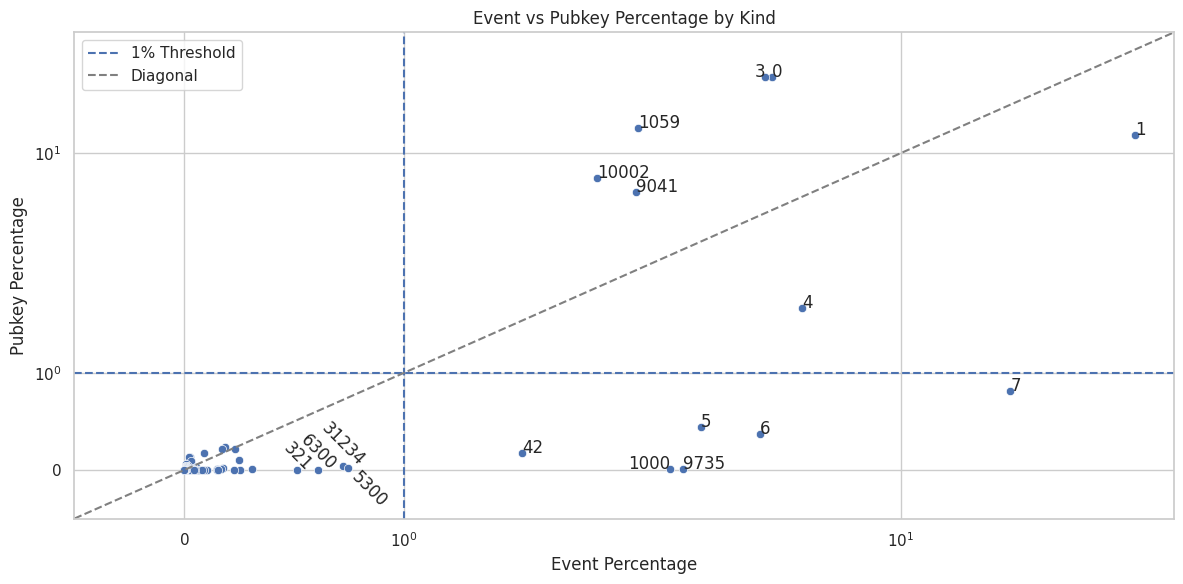

In [11]:
plt.figure()

sns.scatterplot(
    data=merged,
    x='perc_event',
    y='perc_pubkey',
)

plt.xlabel('Event Percentage')
plt.ylabel('Pubkey Percentage')
plt.title('Event vs Pubkey Percentage by Kind')
plt.xscale('symlog')
plt.yscale('symlog')
plt.tight_layout()

min_val = min(merged['perc_event'].min(), merged['perc_pubkey'].min())
max_val = max(merged['perc_event'].max(), merged['perc_pubkey'].max())

# Imposta gli stessi limiti per entrambi gli assi
plt.xlim(min_val-0.5, max_val+10)
plt.ylim(min_val-0.5, max_val+10)

# add label per ogni punto solo se il valore è maggiore di 0.1
for i in range(len(merged)):
    if merged['perc_event'].iloc[i] >= 0.5 or merged['perc_pubkey'].iloc[i] >= 0.5:
        if merged['kind'].iloc[i] in [321, 6300, 31234]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='center',
                va='baseline',
                rotation=-45
            )
        elif merged['kind'].iloc[i] in [5300]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='left',
                va='top',
                rotation=-45
            )
        elif merged['kind'].iloc[i] not in [3, 1000]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='left',
                va='baseline',
            )
        elif merged['kind'].iloc[i] in [3, 1000]:
            plt.text(
                merged['perc_event'].iloc[i],
                merged['perc_pubkey'].iloc[i],
                merged['kind'].iloc[i],
                ha='right',
                va='baseline',
            )
        
plt.axhline(y=1, linestyle='--', label='1% Threshold')
plt.axvline(x=1, linestyle='--')
# plot bisettrice line
plt.plot([min_val-0.5, max_val+10], [min_val-0.5, max_val+10], linestyle='--', color='gray', label='Diagonal')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
kinds_info = pd.read_csv(os.path.join(DATA_FOLDER, 'kinds_info.csv'))
relevant_kinds = merged[(merged['perc_event'] >= 0.5) | (merged['perc_pubkey'] >= 0.5)].filter(['kind'])
relevant_kinds = relevant_kinds.merge(kinds_info, on='kind', how='left')
relevant_kinds

,kind,title,linked_code,file_name,status
0,0,User Metadata,01,01.md,NaN
1,3,Follows,02,02.md,NaN
2,1059,Gift Wrap,59,59.md,NaN
3,1,Short Text Note,10,10.md,NaN
4,10002,Relay List Metadata,65,65.md,NaN
5,9041,Zap Goal,75,75.md,NaN
6,4,Encrypted Direct Messages,04,04.md,NaN
7,7,Reaction,25,25.md,NaN
8,5,Event Deletion Request,09,09.md,NaN
9,6,Repost,18,18.md,NaN


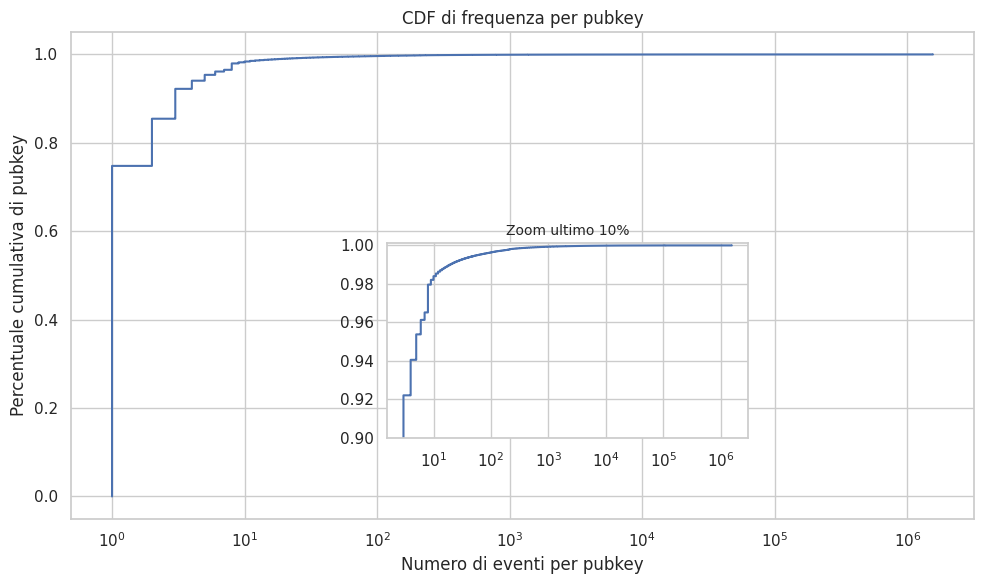

In [13]:
# Calcolo frequenze
pubkey_counts = (
    events
    .group_by(["pubkey"])
    .agg(pl.count().alias("num_events"))
)

freq = pubkey_counts["num_events"].to_list()
freq_sorted = np.sort(freq)
cdf = np.arange(1, len(freq_sorted) + 1) / len(freq_sorted)

# Grafico principale
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(freq_sorted, cdf, where='post', label='CDF di frequenza per pubkey')
ax.set_xlabel('Numero di eventi per pubkey')
ax.set_ylabel('Percentuale cumulativa di pubkey')
ax.set_title('CDF di frequenza per pubkey')
ax.set_xscale('log')
ax.grid(True)

# Zoom: filtro con CDF >= 0.9
mask = cdf >= 0.9
freq_zoom = freq_sorted[mask]
cdf_zoom = cdf[mask]

# Sottografo (inset)
ax_inset = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc='lower center',
        bbox_to_anchor=(0.05, 0.15, 1, 1),  # (x0, y0, width, height) relative to ax
        bbox_transform=ax.transAxes
    )
ax_inset.step(freq_zoom, cdf_zoom, where='post')
ax_inset.set_xscale('log')
ax_inset.set_ylim(0.9, 1.001)
ax_inset.set_title('Zoom ultimo 10%', fontsize=10)
ax_inset.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Conta quante volte appare ogni pubkey
counts = events.group_by("pubkey").agg([
    pl.count().alias("num_events")
])

# Filtra solo le pubkey che appaiono una volta
single_use_pubkeys = counts.filter(
    pl.col("num_events") == 1
).select("pubkey")

# Fai un inner join per mantenere solo gli eventi di quelle pubkey
filtered_events = events.join(single_use_pubkeys, on="pubkey", how="inner")

kind_stats = filtered_events.group_by("kind").agg([
    pl.count().alias("count")
]).sort("count", descending=True)

# Calcola la percentuale
total = kind_stats["count"].sum()
kind_stats = kind_stats.with_columns([
    (pl.col("count") / total * 100).alias("percentage")
])
print("Statistiche per kind di eventi con pubkey che appaiono una sola volta:")
display(kind_stats.head(10))

# fai la stessa cosa ma per il top 1% delle pubkey che pubblicano piu'; eventi in assoluto
top_1_percent_pubkeys = (
    events.group_by("pubkey")
    .agg(pl.count().alias("num_events"))
    .sort("num_events", descending=True)
    .head(int(0.01 * events["pubkey"].n_unique()))
    .select("pubkey")
)

# Fai un inner join per mantenere solo gli eventi di quelle pubkey
filtered_events_top_1 = events.join(top_1_percent_pubkeys, on="pubkey", how="inner")
kind_stats_top_1 = filtered_events_top_1.group_by("kind").agg([
    pl.count().alias("count")
]).sort("count", descending=True)   

# Calcola la percentuale
total_top_1 = kind_stats_top_1["count"].sum()
kind_stats_top_1 = kind_stats_top_1.with_columns([
    (pl.col("count") / total_top_1 * 100).alias("percentage")
])
print("Statistiche per kind di eventi con pubkey che appartengono al top 1% per numero di eventi:")
display(kind_stats_top_1.head(10))

Statistiche per kind di eventi con pubkey che appaiono una sola volta:


kind,count,percentage
i64,u32,f64
3,5424600,36.856409
0,4318903,29.343962
1059,3748147,25.466069
1,691000,4.694868
4,212725,1.445319
10002,143065,0.972028
5,36291,0.246572
5314,36127,0.245458
9041,28134,0.191151


Statistiche per kind di eventi con pubkey che appartengono al top 1% per numero di eventi:


kind,count,percentage
i64,u32,f64
1,62168338,44.136141
7,32301481,22.932296
4,9089356,6.452949
6,7517229,5.336824
5,5266607,3.739005
9735,4854038,3.446103
1000,4499363,3.194303
42,2568032,1.823163
5300,1279594,0.908442


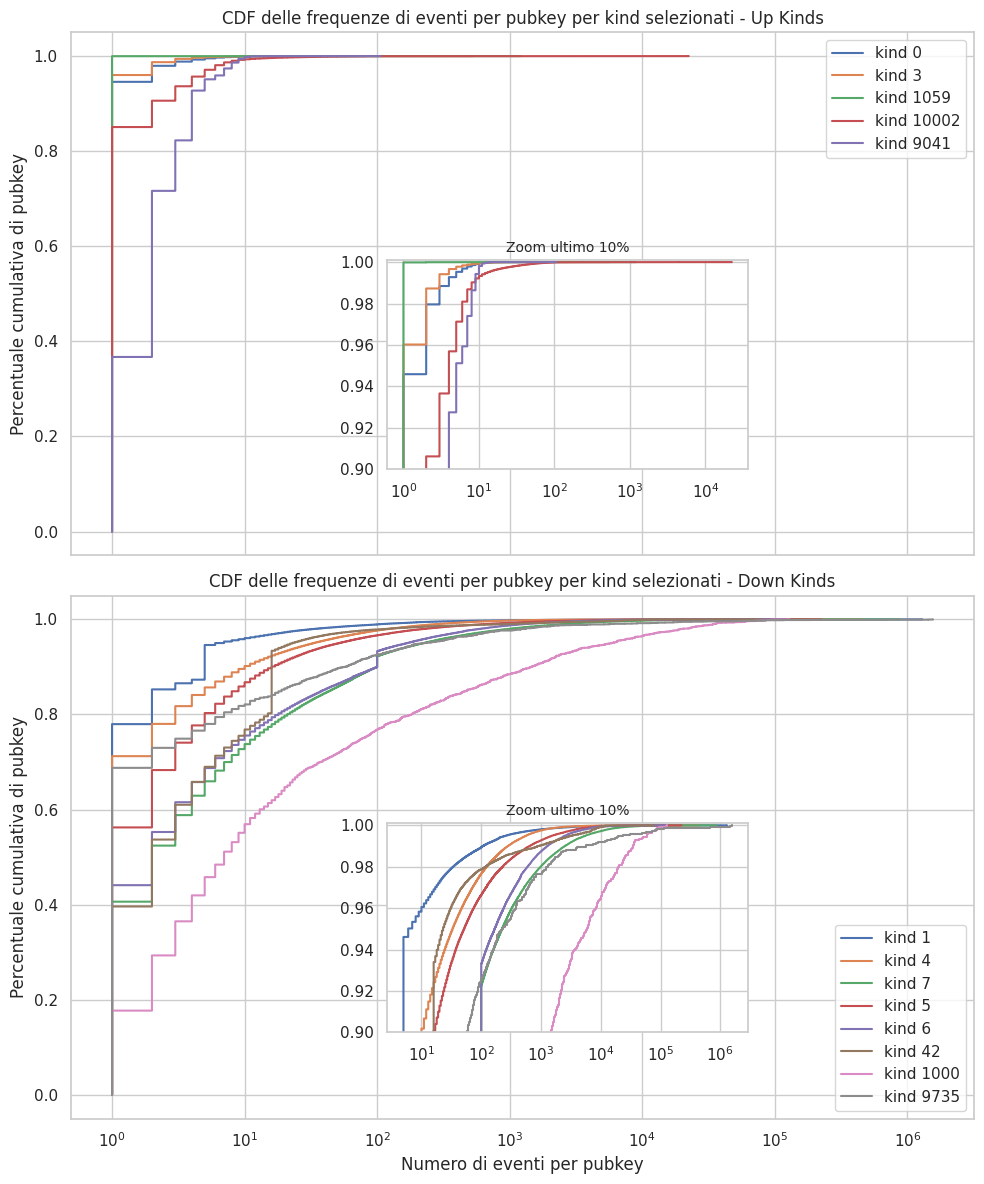

In [15]:
selected_kinds = relevant_kinds["kind"].to_list()

# Filtra eventi per i kind selezionati
events_filtered = events.filter(pl.col("kind").is_in(selected_kinds))

# Raggruppa per pubkey e kind e conta numero di eventi
pubkey_kind_counts = (
    events_filtered
    .group_by(["pubkey", "kind"])
    .agg(pl.count().alias("num_events"))
)

up_kinds = merged[(merged["perc_event"] < merged["perc_pubkey"]) & ((merged['perc_event'] >= 1) | (merged['perc_pubkey'] >= 1))]['kind'].to_list()
down_kinds = merged[(merged["perc_event"] >= merged["perc_pubkey"]) & ((merged['perc_event'] >= 1) | (merged['perc_pubkey'] >= 1))]['kind'].to_list()

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for ax, kinds, title in zip(axes, [up_kinds, down_kinds], ['Up Kinds', 'Down Kinds']):
    # Crea inset una sola volta per subplot, in basso a destra
    ax_inset = inset_axes(
        ax,
        width="40%",
        height="40%",
        loc='lower center',
        bbox_to_anchor=(0.05, 0.15, 1, 1),  # (x0, y0, width, height) relative to ax
        bbox_transform=ax.transAxes
    )

    for kind in kinds:
        filtered = pubkey_kind_counts.filter(pl.col("kind") == kind)
        freq = filtered["num_events"].to_list()
        if len(freq) == 0:
            continue
        freq_sorted = np.sort(freq)
        cdf = np.arange(1, len(freq_sorted) + 1) / len(freq_sorted)

        # Plot CDF completa nel subplot principale
        ax.step(freq_sorted, cdf, where='post', label=f"kind {kind}")

        # Plot CDF zoomata nell'inset (ultimo 10%)
        mask = cdf >= 0.9
        freq_zoom = freq_sorted[mask]
        cdf_zoom = cdf[mask]
        ax_inset.step(freq_zoom, cdf_zoom, where='post', label=f"kind {kind}")

    ax.set_ylabel("Percentuale cumulativa di pubkey")
    ax.set_title(f"CDF delle frequenze di eventi per pubkey per kind selezionati - {title}")
    ax.grid(True)
    ax.legend()

    # Configura inset
    ax_inset.set_xscale('log')
    ax_inset.set_ylim(0.9, 1.001)
    ax_inset.set_title("Zoom ultimo 10%", fontsize=10)
    ax_inset.grid(True)

axes[-1].set_xlabel("Numero di eventi per pubkey")
axes[-1].set_xscale('log')

plt.tight_layout()
plt.show()

In [16]:
def foo(sets):
    all_keys = list(sets.keys())
    total_pubkeys = len(set.union(*sets.values()))
    intersections = {}
    for i in range(1, len(all_keys)+1):
        for combo in combinations(all_keys, i):
            intersect = set.intersection(*[sets[k] for k in combo])
            intersections[combo] = {
                "count": len(intersect),
                "perc": (len(intersect) / total_pubkeys * 100) if total_pubkeys > 0 else 0
            }
    rows = []
    for combo, stats in intersections.items():
        rows.append({
            "kind_combination": ", ".join(combo),
            "count": stats["count"],
            "perc": stats["perc"]
        })
    intersections_df = pd.DataFrame(rows)
    # Ordina per numero di pubkey
    intersections_df = intersections_df.sort_values(by='count', ascending=False).reset_index(drop=True)
    return intersections_df

Total unique pubkeys: 19681031
Unique pubkeys in kinds 0, 3, 1, 6, 7: 15268930 (77.58%)


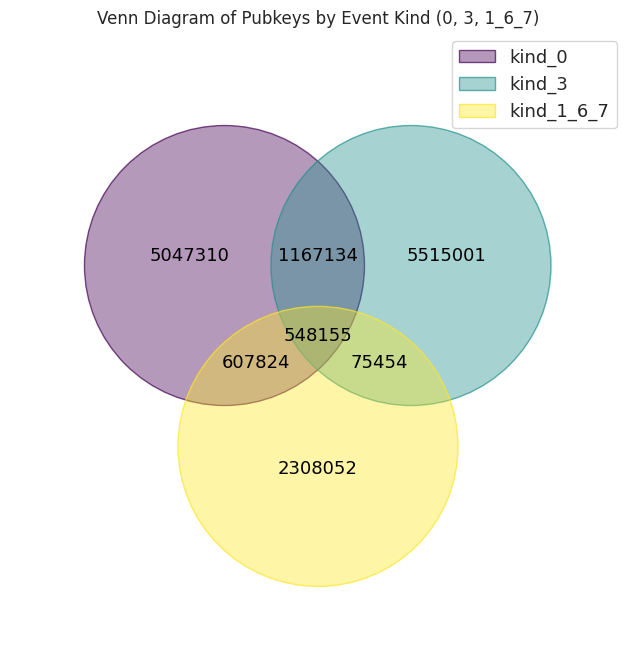

,kind_combination,count,perc
0,kind_0,7370423,48.270724
1,kind_3,7305744,47.847125
2,kind_1_6_7,3539485,23.180963
3,"kind_0, kind_3",1715289,11.233852
4,"kind_0, kind_1_6_7",1155979,7.570792
5,"kind_3, kind_1_6_7",623609,4.084170
6,"kind_0, kind_3, kind_1_6_7",548155,3.590003


In [17]:
# Crea i set per ciascun tipo di evento
kind_0 = set(events.filter(pl.col("kind") == 0).select("pubkey").to_series().to_list())
kind_3 = set(events.filter(pl.col("kind") == 3).select("pubkey").to_series().to_list())
kind_1_6_7 = set(events.filter(pl.col("kind").is_in([1, 6, 7])).select("pubkey").to_series().to_list())

kind_sets = {
    "kind_0": kind_0,
    "kind_3": kind_3,
    "kind_1_6_7": kind_1_6_7
}

all_pubkeys_count = events.select(
    pl.col("pubkey").n_unique()
).to_series().item()
all_kind_pubkeys_count = events.filter(
    pl.col("kind").is_in([0, 3, 1, 6, 7])
).select(
    pl.col("pubkey").n_unique()
).to_series().item()
print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 0, 3, 1, 6, 7: {all_kind_pubkeys_count} ({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")

# --- Step 2: Plotta il diagramma di Venn per i 4 insiemi ---
venn(kind_sets)
plt.title("Venn Diagram of Pubkeys by Event Kind (0, 3, 1_6_7)")
plt.show()

foo(kind_sets)

Total unique pubkeys: 19681031
Unique pubkeys in kinds 1, 6, 7: 3539485 (17.98%)


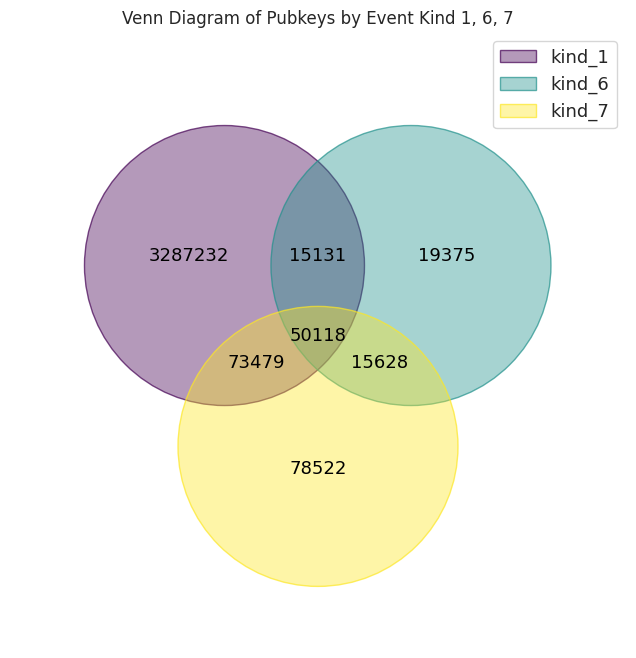

,kind_combination,count,perc
0,kind_1,3425960,96.792612
1,kind_7,217747,6.151940
2,"kind_1, kind_7",123597,3.491949
3,kind_6,100252,2.832389
4,"kind_6, kind_7",65746,1.857502
5,"kind_1, kind_6",65249,1.843460
6,"kind_1, kind_6, kind_7",50118,1.415969


In [18]:
# Crea i set per kind 1, 6, 7
kind_1 = set(events.filter(pl.col("kind") == 1).select("pubkey").to_series().to_list())
kind_6 = set(events.filter(pl.col("kind") == 6).select("pubkey").to_series().to_list())
kind_7 = set(events.filter(pl.col("kind") == 7).select("pubkey").to_series().to_list())

# Dizionario dei set
sets = {
    "kind_1": kind_1,
    "kind_6": kind_6,
    "kind_7": kind_7
}

all_pubkeys_count = events.select(
    pl.col("pubkey").n_unique()
).to_series().item()
all_kind_pubkeys_count = events.filter(
    pl.col("kind").is_in([1, 6, 7])
).select(
    pl.col("pubkey").n_unique()
).to_series().item()
print(f"Total unique pubkeys: {all_pubkeys_count}")
print(f"Unique pubkeys in kinds 1, 6, 7: {all_kind_pubkeys_count} ({all_kind_pubkeys_count / all_pubkeys_count * 100:.2f}%)")


# Genera il diagramma di Venn
venn(sets)
plt.title("Venn Diagram of Pubkeys by Event Kind 1, 6, 7")
plt.show()

foo(sets)

In [19]:
#add col in events ad day from created_at as a second time series
events = events.with_columns([
    (pl.col("created_at") * 1000).cast(pl.Datetime("ms")).dt.date().alias("day")
])

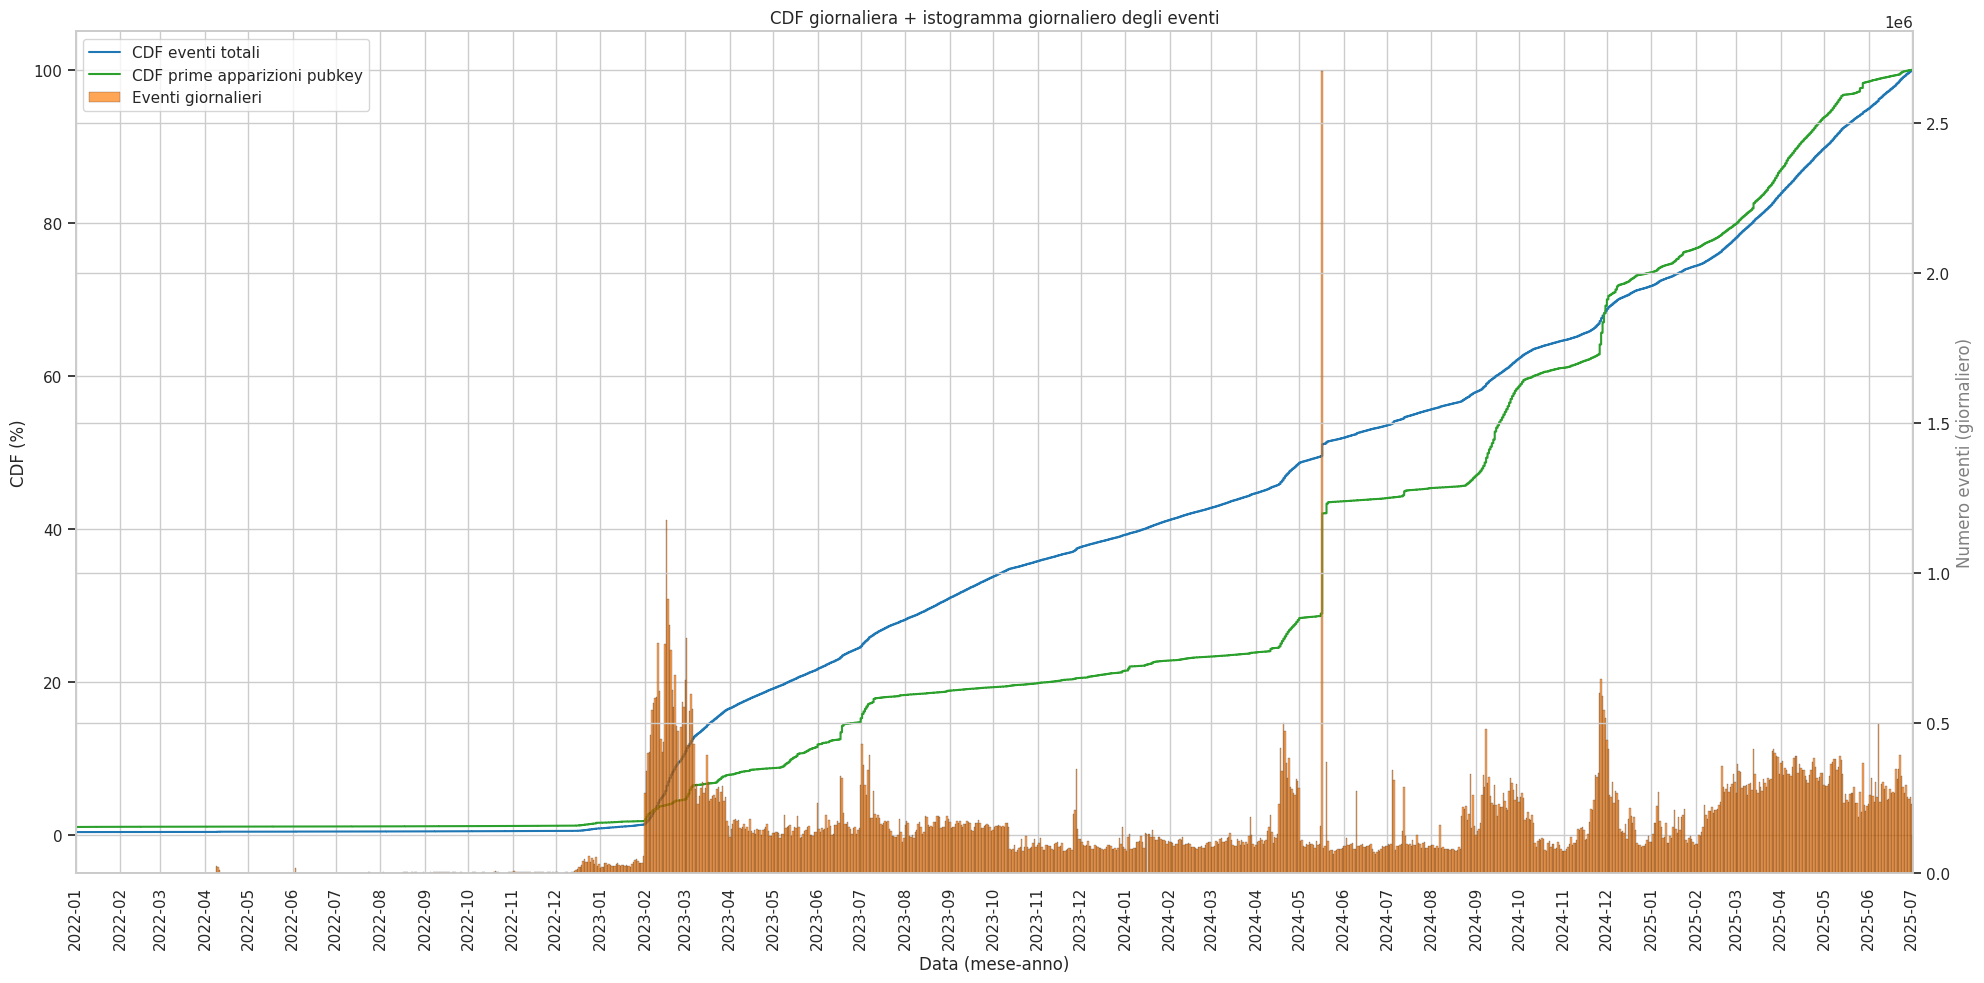

In [20]:
# --- CDF eventi totali ---
daily = events.group_by("day").agg([
    pl.count().alias("count")
]).sort("day")

total = daily["count"].sum()
cdf_df = daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count")
]).with_columns([
    (pl.col("cum_count") / total * 100).alias("cdf")
])

# --- CDF prime apparizioni ---
first_events = events.group_by("pubkey").agg([
    pl.min("created_at").alias("first_created_at")
])
first_events = first_events.with_columns([
    (pl.col("first_created_at")*1000).cast(pl.Datetime("ms")).dt.date().alias("first_day")
])

first_daily = first_events.group_by("first_day").agg([
    pl.count().alias("count")
]).sort("first_day")

total_first = first_daily["count"].sum()
cdf_first_df = first_daily.with_columns([
    pl.col("count").cum_sum().alias("cum_count")
]).with_columns([
    (pl.col("cum_count") / total_first * 100).alias("cdf")
])

# --- Aggregazione mensile per istogramma ---
monthly = events.with_columns([
    pl.col("day").dt.truncate("1mo").alias("month")
]).group_by("month").agg([
    pl.count().alias("monthly_count")
]).sort("month")

# --- Prepara dati per plotting ---
days = pd.to_datetime(cdf_df["day"].to_pandas())
cdf_values = cdf_df["cdf"].to_numpy()

first_days = pd.to_datetime(cdf_first_df["first_day"].to_pandas())
cdf_first_values = cdf_first_df["cdf"].to_numpy()

hist_days = pd.to_datetime(daily["day"].to_pandas())
hist_counts = daily["count"].to_numpy()

# --- Plot ---
fig, ax = plt.subplots(figsize=(20, 10))

# Primo asse Y: CDF
ax.plot(days, cdf_values, drawstyle="steps-post", label="CDF eventi totali", color="tab:blue")
ax.plot(first_days, cdf_first_values, drawstyle="steps-post", label="CDF prime apparizioni pubkey", color="tab:green")

ax.set_xlabel("Data (mese-anno)")
ax.set_ylabel("CDF (%)")
ax.set_xlim(pd.to_datetime("2022-01-01"), max(days.max(), first_days.max()))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(axis='x', rotation=90)
ax.grid(True)

# Secondo asse Y: istogramma eventi giornalieri
ax2 = ax.twinx()
ax2.bar(
    hist_days,
    hist_counts,
    width=1.0,
    alpha=0.7,
    color="tab:orange",
    edgecolor="black",
    linewidth=0.2,
    label="Eventi giornalieri",
    zorder=0
)
ax2.set_ylabel("Numero eventi (giornaliero)", color="gray")

# Legenda combinata
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("CDF giornaliera + istogramma giornaliero degli eventi")
plt.tight_layout()
plt.show()

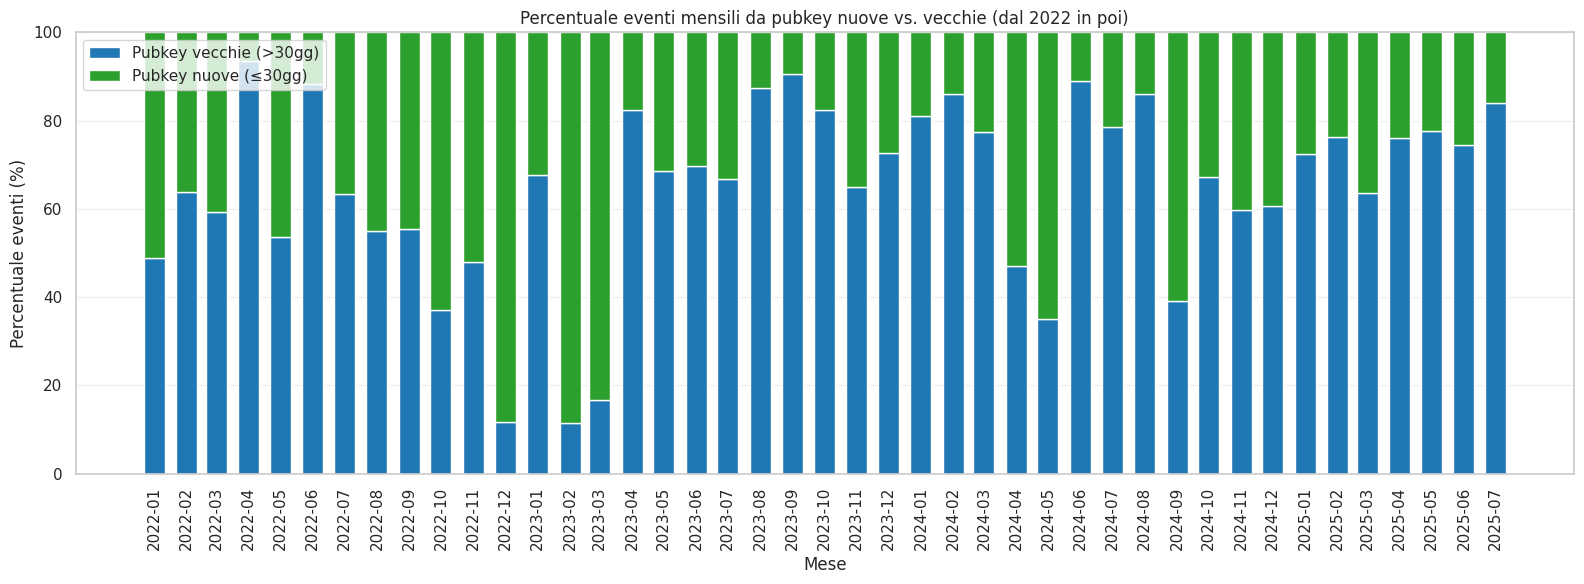

In [21]:
# --- Step 1: Usa la colonna day e calcola mese degli eventi ---
events_with_month = events.with_columns([
    pl.col("day").dt.truncate("1mo").alias("month")
])

# --- Step 2: Primo mese di apparizione per ogni pubkey ---
first_months_df = events_with_month.select(["pubkey", "month"]).group_by("pubkey").min()

# --- Step 3: Join per aggiungere first_month ---
joined = events_with_month.join(first_months_df, on="pubkey", suffix="_first")

# --- Step 4: Calcola età pubkey in giorni tra month evento e first_month ---
joined = joined.with_columns([
    (pl.col("month").cast(pl.Datetime("ns")) - pl.col("month_first").cast(pl.Datetime("ns"))).alias("duration")
])
joined = joined.with_columns([
    (pl.col("duration").cast(pl.Int64) // 86_400_000_000_000).alias("age_days")
])

# --- Step 5: Etichetta nuova o vecchia (<=30 giorni nuova) ---
joined = joined.with_columns([
    (pl.col("age_days") <= 30).alias("is_new")
])

# --- Step 6: Conta eventi mensili per nuova/vecchia ---
monthly_counts = joined.group_by(["month", "is_new"]).agg(
    pl.count().alias("count")
).sort("month")

# --- Step 7: Converti in pandas e pivot ---
df = monthly_counts.to_pandas()
df["month"] = pd.to_datetime(df["month"])
df_pivot = df.pivot(index="month", columns="is_new", values="count").fillna(0)

# Assicurati che entrambe le colonne (True/False) esistano
for col in [True, False]:
    if col not in df_pivot.columns:
        df_pivot[col] = 0

df_pivot = df_pivot.rename(columns={False: "old_pubkey_events", True: "new_pubkey_events"})
df_pivot = df_pivot.sort_index()

# --- Step 8: Calcola percentuali ---
df_pivot["total"] = df_pivot["new_pubkey_events"] + df_pivot["old_pubkey_events"]
df_pivot["pct_new"] = df_pivot["new_pubkey_events"] * 100 / df_pivot["total"]
df_pivot["pct_old"] = df_pivot["old_pubkey_events"] * 100 / df_pivot["total"]

# --- Step 9: Filtra mesi dal 2022 in poi ---
df_pivot = df_pivot[df_pivot.index >= pd.Timestamp("2022-01-01")]

# --- Step 10: Plot - Istogramma impilato (percentuale per mese) ---
plt.figure(figsize=(16, 6))

months = df_pivot.index
bar_width = 20  # larghezza delle barre in giorni

# Convertiamo l'indice (Timestamp) in numeri per matplotlib
month_nums = mdates.date2num(months)

# Dati
pct_old = df_pivot["pct_old"].values
pct_new = df_pivot["pct_new"].values

# Disegno barre impilate
plt.bar(month_nums, pct_old, width=bar_width, label="Pubkey vecchie (>30gg)", color="#1f77b4")
plt.bar(month_nums, pct_new, bottom=pct_old, width=bar_width, label="Pubkey nuove (≤30gg)", color="#2ca02c")

# Asse X: etichette formato mese
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(month_nums, [d.strftime('%Y-%m') for d in months], rotation=90)

# Etichette e layout
plt.ylabel("Percentuale eventi (%)")
plt.xlabel("Mese")
plt.title("Percentuale eventi mensili da pubkey nuove vs. vecchie (dal 2022 in poi)")
plt.ylim(0, 100)
plt.legend(loc="upper left")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

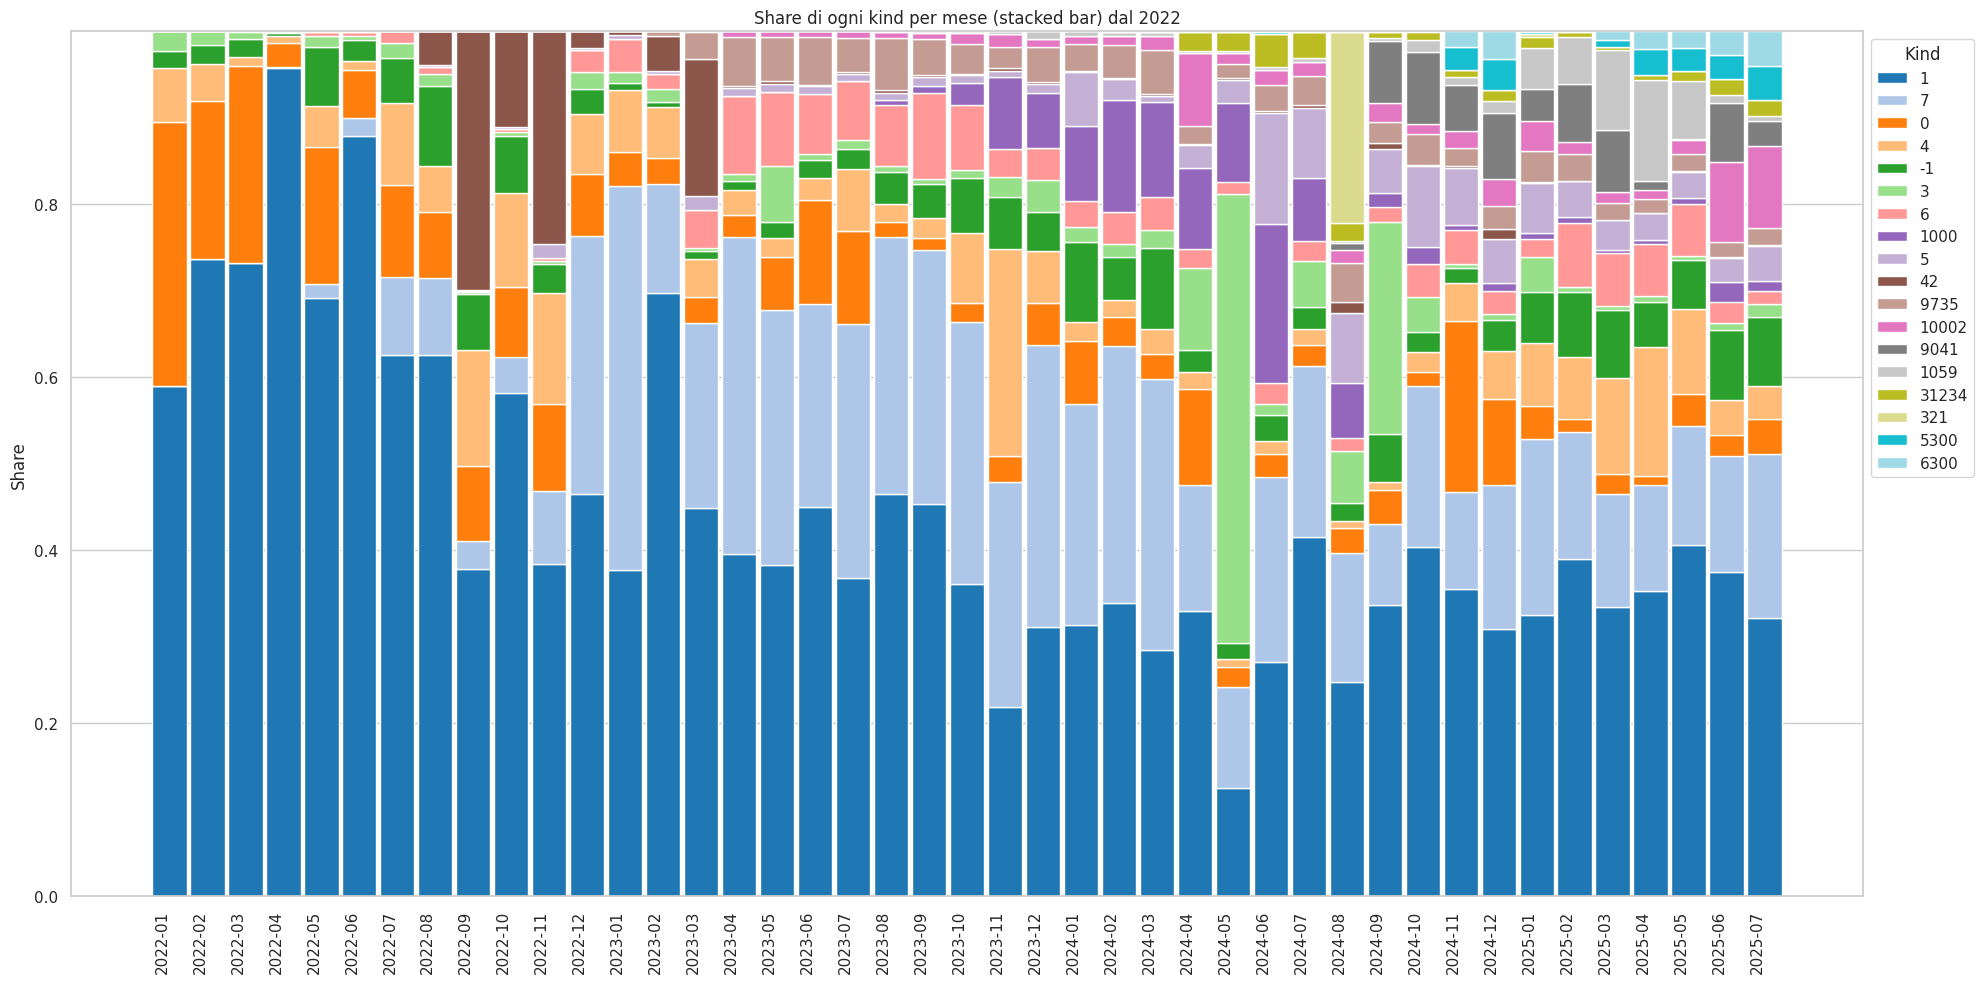

In [22]:
# Estrai mese (primo giorno del mese)
events_with_month = events.with_columns([
    pl.col("day").dt.truncate("1mo").alias("month")
])

# Sostituisci i kind non rilevanti con -1
events_masked = events_with_month.with_columns([
    pl.when(pl.col("kind").is_in(relevant_kinds["kind"].to_list()))
      .then(pl.col("kind"))
      .otherwise(-1)
      .alias("kind")
])

# Conta eventi per mese e kind
count_df = events_masked.group_by(["month", "kind"]).agg(
    pl.count().alias("count_kind")
)

# Conta eventi totali per mese
total_df = events_with_month.group_by("month").agg(
    pl.count().alias("total_month")
)

# Unione conteggi
joined = count_df.join(total_df, on="month")

# Calcola share
result = joined.with_columns(
    (pl.col("count_kind") / pl.col("total_month")).alias("share")
)

# Pivot: mesi come righe, kind come colonne
pivot = result.pivot(
    values="share",
    index="month",
    columns="kind"
).fill_null(0).sort("month")

# Filtra mesi dal 2022-01 in poi
filter_date = date(2022, 1, 1)
filtered_pivot = pivot.filter(pl.col("month") >= filter_date)

# Converti mese in stringa per asse x
filtered_months_str = [
    m.strftime("%Y-%m") for m in filtered_pivot["month"].to_list()
]

# Prendi i kind (escluse colonne non numeriche)
kinds = [col for col in filtered_pivot.columns if col != "month"]

# Ordina i kind per somma decrescente degli share totali
kinds_sorted = sorted(
    kinds,
    key=lambda k: filtered_pivot[k].sum(),
    reverse=True
)

# Prepara dati ordinate per stacked bar
filtered_data = {kind: filtered_pivot[kind].to_list() for kind in kinds_sorted}

# Colori distinti
num_kinds = len(kinds_sorted)
cmap = cm.get_cmap("tab20", num_kinds)
colors = [cmap(i) for i in range(num_kinds)]

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
bottom = np.zeros(len(filtered_months_str))
bar_width = 0.9

for i, kind in enumerate(kinds_sorted):
    shares = filtered_data[kind]
    ax.bar(filtered_months_str, shares, bottom=bottom, label=str(kind), color=colors[i], width=bar_width)
    bottom += np.array(shares)

ax.set_ylabel("Share")
ax.set_title("Share di ogni kind per mese (stacked bar) dal 2022")
ax.legend(title="Kind", loc="upper left", bbox_to_anchor=(1, 1))
fig.autofmt_xdate(rotation=90)

plt.tight_layout()
plt.show()

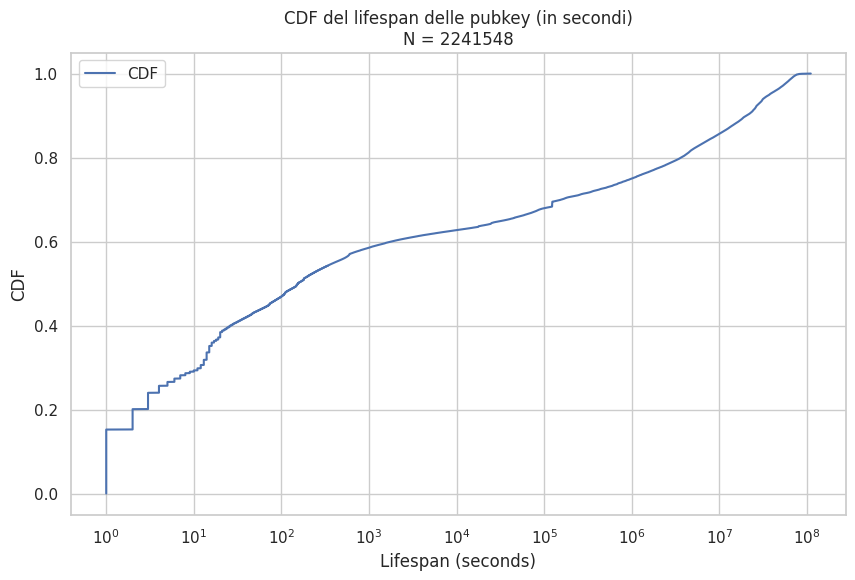

In [23]:
# Parametri personalizzabili
start_date = "2022-01-01"  # oppure None
end_date = None
log_scale = None  # oppure True / False
time_unit = "seconds"
factor = 1  # secondi, con frazioni consentite

# Filtro temporale (opzionale)
filtered_events = events
if start_date:
    start_ts = int(datetime.datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    filtered_events = filtered_events.filter(pl.col("created_at") >= start_ts)
if end_date:
    end_ts = int(datetime.datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    filtered_events = filtered_events.filter(pl.col("created_at") <= end_ts)

# Calcola lifespan per pubkey (float, in secondi)
lifespans = (
    filtered_events.group_by("pubkey")
    .agg([
        pl.col("created_at").min().alias("min_created"),
        pl.col("created_at").max().alias("max_created"),
    ])
    .with_columns(
        ((pl.col("max_created") - pl.col("min_created")) / factor)
        .cast(pl.Float64)
        .alias("lifespan")
    )
    .filter(pl.col("lifespan") > 0)  # rimuovi lifespan = 0
)

# Estrai e ordina lifespan
lifespan_sorted = lifespans.select("lifespan").to_numpy().flatten()
if len(lifespan_sorted) == 0:
    print("Nessun dato disponibile (tutte le pubkey hanno lifespan = 0 o nessun dato nel range).")
else:
    lifespan_sorted = np.sort(lifespan_sorted)
    cdf = np.arange(1, len(lifespan_sorted) + 1) / len(lifespan_sorted)

    # Scala log automatica se non specificata
    if log_scale is None:
        log_scale = lifespan_sorted.min() > 0 and lifespan_sorted.max() / lifespan_sorted.min() > 100

    # Plot principale
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(lifespan_sorted, cdf, label='CDF')

    if log_scale:
        ax.set_xscale('log')

    ax.set_xlabel("Lifespan (seconds)")
    ax.set_ylabel("CDF")
    ax.set_title(f"CDF del lifespan delle pubkey (in secondi)\nN = {len(lifespan_sorted)}")
    ax.grid(True)
    ax.legend()

    # # ==== INSET PLOT (ultimo 10%) ====
    # # Seleziona l'ultimo 10% dei dati
    # threshold = int(len(lifespan_sorted) * 0.9)
    # x_inset = lifespan_sorted[threshold:]
    # y_inset = cdf[threshold:]

    # # Aggiungi inset
    # inset_ax = inset_axes(ax, width="40%", height="40%", loc='lower right')
    # inset_ax.plot(x_inset, y_inset, color='orange')
    # inset_ax.set_title("Ultimo 10%", fontsize=10)

    # if log_scale:
    #     inset_ax.set_xscale('log')

    # inset_ax.grid(True)
    # inset_ax.tick_params(labelsize=8)

    plt.show()

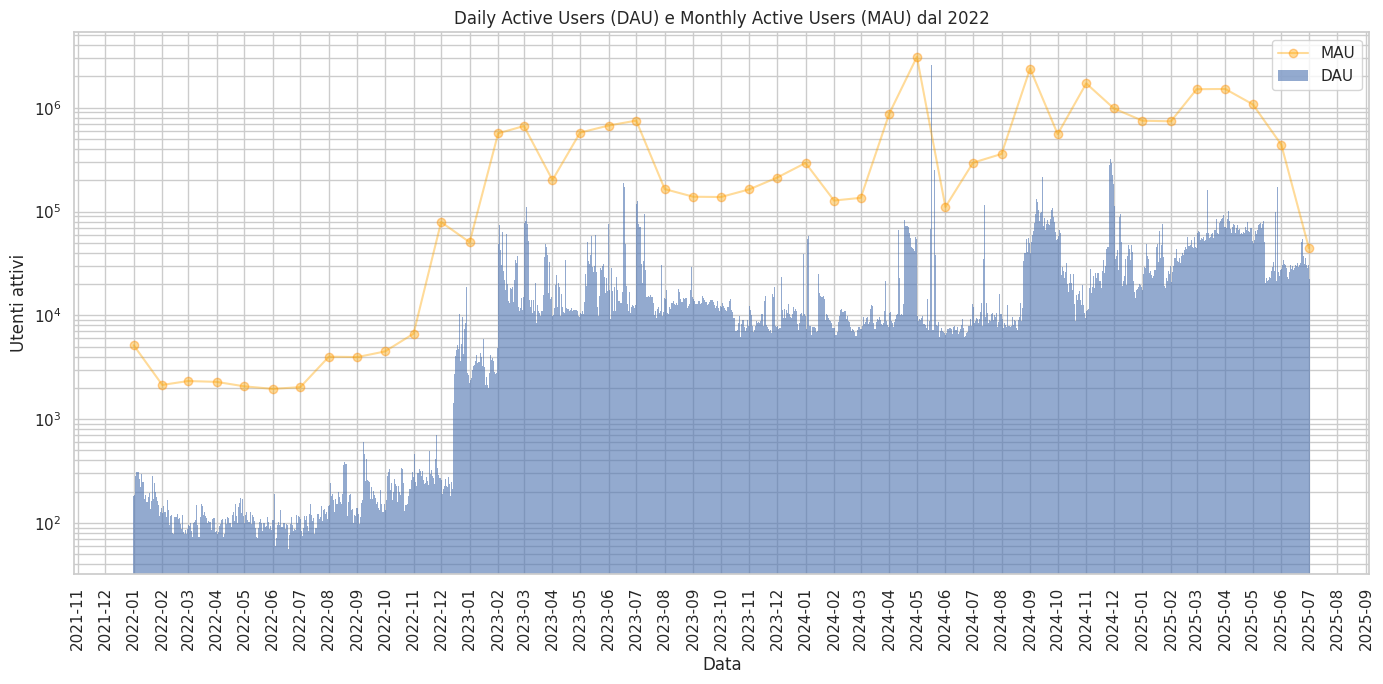

In [24]:
import polars as pl
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

# Step 1: Converti timestamp in data
df = events.with_columns(
    pl.from_epoch("created_at", time_unit="s").dt.date().alias("day")
)

# Step 2: Filtra eventi dal 2022 in poi
df = df.filter(pl.col("day") >= datetime.date(2022, 1, 1))

# Step 3: Calcola DAU (giornaliero)
dau = (
    df.select(["day", "pubkey"])
      .unique(subset=["day", "pubkey"])
      .group_by("day")
      .agg(pl.count().alias("DAU"))
      .sort("day")
)

# Step 4: Calcola MAU (mensile)
df = df.with_columns(
    pl.col("day").dt.truncate("1mo").alias("month")  # tronca a inizio mese
)

mau = (
    df.select(["month", "pubkey"])
      .unique(subset=["month", "pubkey"])
      .group_by("month")
      .agg(pl.count().alias("MAU"))
      .sort("month")
)

# Step 5: Plot DAU e MAU
plt.figure(figsize=(14, 7))

# Istogramma DAU
plt.bar(dau["day"].to_numpy(), dau["DAU"].to_numpy(), label="DAU", edgecolor='none', alpha=0.6, width=1)

# Linea MAU con punti e linea meno visibile
plt.plot(
    mau["month"].to_numpy(), 
    mau["MAU"].to_numpy(), 
    label="MAU", 
    color='orange', 
    linewidth=1.5,
    alpha=0.4,
    marker='o',
    markersize=6,
    markerfacecolor='orange',
    markeredgecolor='darkorange'
)

plt.xlabel("Data")
plt.ylabel("Utenti attivi")
plt.title("Daily Active Users (DAU) e Monthly Active Users (MAU) dal 2022")
plt.legend()

plt.yscale('log')  # opzionale: scala logaritmica
plt.grid(True, which='both', axis='y')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # tick ogni mese
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [25]:
# Ordina per pubkey e timestamp
events_sorted = events.sort(['pubkey', 'created_at'])

# Calcola il tempo tra eventi consecutivi per ogni pubkey
events_with_delta = events_sorted.with_columns([
    pl.col("created_at").diff().over("pubkey").alias("delta_t")
])

# Raggruppa per pubkey e calcola media e varianza del delta_t
stats = events_with_delta.group_by("pubkey").agg([
    pl.col("delta_t").mean().alias("mean_interval"),
    pl.col("delta_t").var().alias("var_interval"),
    pl.count().alias("event_count")
])

# Filtra solo le pubkey con almeno 2 eventi
stats = stats.filter(pl.col("event_count") >= 2)

# Calcola frequenza come eventi al giorno (86400 secondi al giorno)
stats = stats.with_columns([
    (86400 / pl.col("mean_interval")).alias("freq_per_day")
])

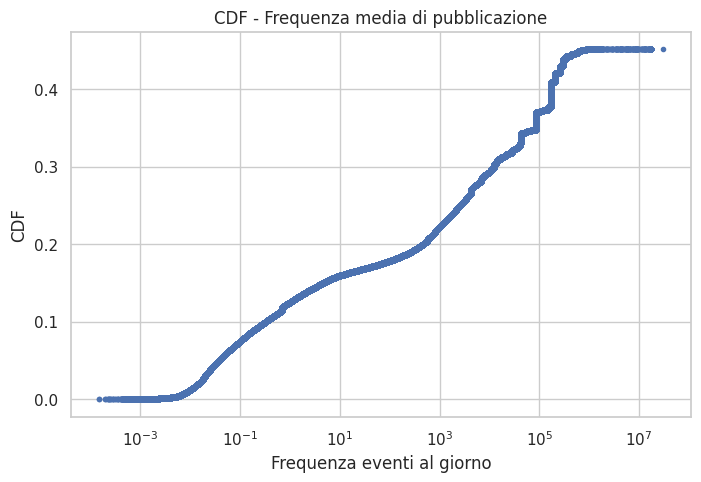

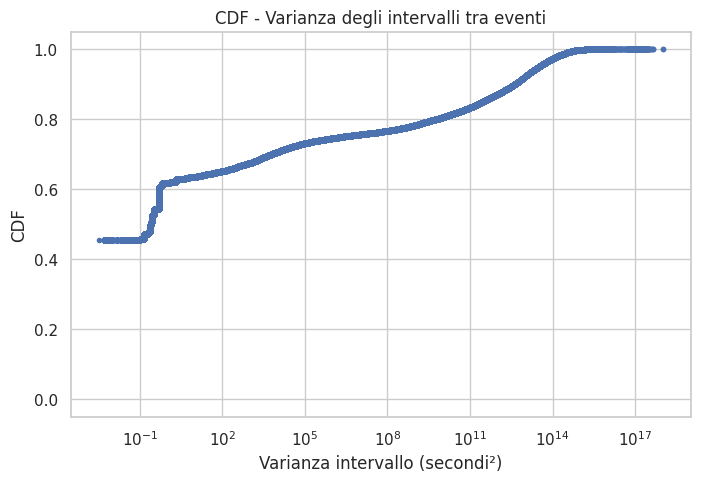

In [26]:
def plot_cdf(data, xlabel, title):
    arr = data.to_numpy()  # converti in numpy array
    arr = arr[~np.isnan(arr)]  # rimuovi NaN
    sorted_data = np.sort(arr)

    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)

    plt.figure(figsize=(8, 5))
    plt.plot(sorted_data, cdf, marker='.', linestyle='none')
    plt.xlabel(xlabel)
    plt.ylabel("CDF")
    plt.title(title)
    plt.grid(True)
    plt.xscale('log')
    plt.show()

plot_cdf(stats["freq_per_day"], "Frequenza eventi al giorno", "CDF - Frequenza media di pubblicazione")
plot_cdf(stats["var_interval"], "Varianza intervallo (secondi²)", "CDF - Varianza degli intervalli tra eventi")


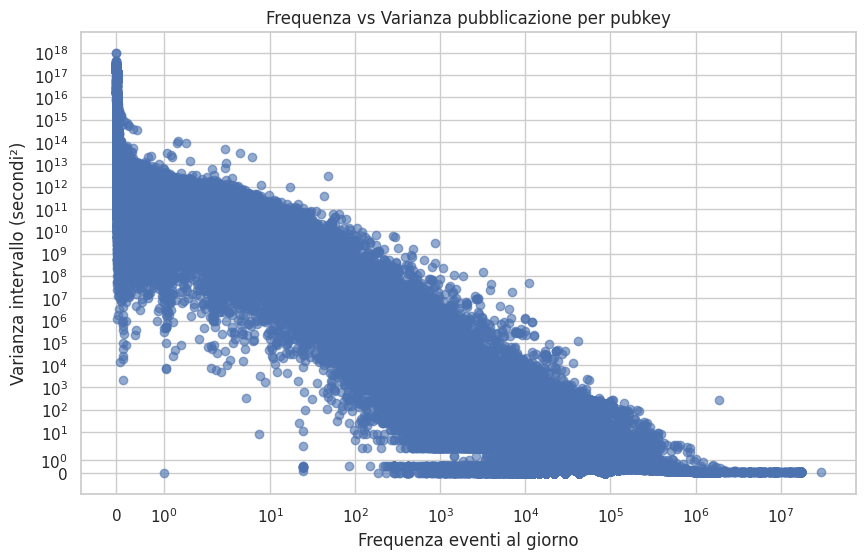

In [27]:
# Converti in pandas per usare matplotlib (Polars non supporta ancora plotting nativamente)
df = stats.to_pandas()

plt.figure(figsize=(10, 6))
plt.scatter(df["freq_per_day"], df["var_interval"], alpha=0.6)
plt.xlabel("Frequenza eventi al giorno")
plt.ylabel("Varianza intervallo (secondi²)")
plt.title("Frequenza vs Varianza pubblicazione per pubkey")
plt.grid(True)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()


- pubkey followers: cdf del numero di followers per pubkey
- correlazione tra eventi pubblicati e follower per pubkey. vedere quali e quante pubkey hanno tanti followers e pubblicano tanto (ele altre tre possibilita')
- pubkey nei relays
- event resilience

In [28]:
# bigbrotr.close()